# k-means clustering demo in 2D

In [1]:
import numpy as np
import numpy.random as npr

import os 

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

from skimage.io import imread, imshow, imsave

import matplotlib.pyplot as plt
%matplotlib inline

def plot_clust(X,W=None,z=None):
    if z is not None:
        if np.any(z<0):
            plt.scatter(X[z<0,0], X[z<0,1], marker="o", 
                        facecolors='none', edgecolor='black', alpha=0.3);
        if np.any(z>=0):
            plt.scatter(X[z>=0,0], X[z>=0,1], marker="o", c=z[z>=0], alpha=0.3);
    else:
        plt.scatter(X[:,0], X[:,1], marker="o", c='black', alpha=0.3);
    if W is not None:
        plt.scatter(W[:,0], W[:,1], marker="^", s=200, c=np.arange(W.shape[0]));
    else:
        plt.title("number of clusters = %d" % len(set(np.unique(z))-set([-1])));

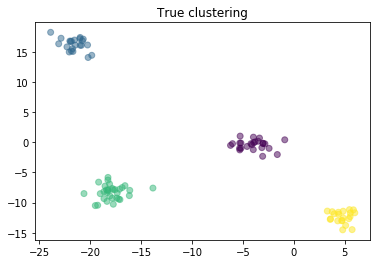

In [2]:
# make up some fake data

npr.seed(2) 
# above: it's fine to delete this, but you might have to
# re-run things a few times to see the effects of interest

n = 100
d = 2
k_true = 4
W_true = npr.randn(k_true,d)*10
z_true = npr.randint(0,k_true,size=n)
X = np.zeros((n,2))
for i in range(n):
    X[i] = W_true[z_true[i]] + npr.randn(d)

plt.scatter(X[:,0], X[:,1], c=z_true, marker="o", alpha=0.5);
plt.title("True clustering");

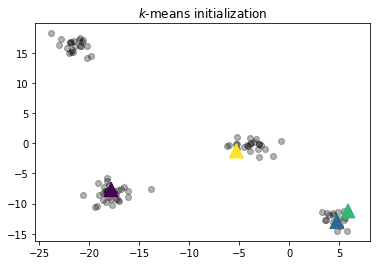

In [3]:
# randomly initialize means

k = 4
W = X[npr.choice(n, k, replace=False)]

plot_clust(X,W)
plt.title("$k$-means initialization");

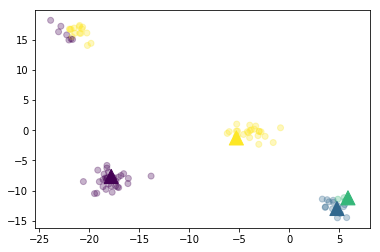

In [4]:
# assign each object to closest mean

def update_z(X,W):
    dist2 = euclidean_distances(X, W)
    return np.argmin(dist2, axis=1)

z = update_z(X,W)
plot_clust(X,W,z)

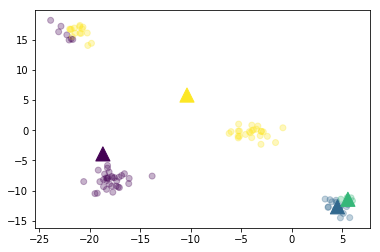

In [5]:
# recompute cluster centres

def update_W(X,z,W_old):
    # just being a bit careful about the case of a cluster with no points in it
    W = W_old.copy()
    for kk in range(k):
        W[kk] = np.mean(X[z==kk],axis=0)
    return W

W = update_W(X,z,W)
plot_clust(X,W,z)

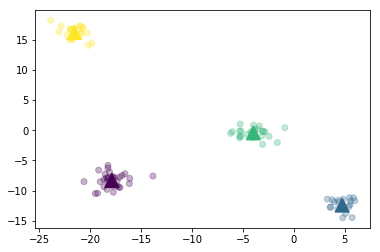

In [6]:
# run the whole thing for 100 iterations
# better: loop until np.all(z_new == z)
for itr in range(100):
    z = update_z(X,W)
    W = update_W(X,z,W)
plot_clust(X,W,z)

In [7]:
W

array([[-17.86258967,  -8.30231749],
       [  4.75460109, -12.40041605],
       [ -3.9696076 ,  -0.42369729],
       [-21.5215559 ,  16.21977151]])

In [8]:
z

array([1, 1, 0, 2, 2, 2, 3, 1, 1, 0, 2, 0, 1, 1, 1, 0, 0, 3, 0, 2, 1, 1,
       3, 2, 2, 0, 0, 1, 1, 3, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 1, 3, 1, 1,
       0, 2, 0, 3, 0, 1, 3, 3, 2, 1, 3, 0, 2, 0, 3, 3, 3, 3, 0, 2, 0, 0,
       1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 3, 0, 3, 0, 0, 0, 1, 2, 0,
       3, 2, 2, 3, 3, 0, 3, 3, 3, 3, 0, 2])

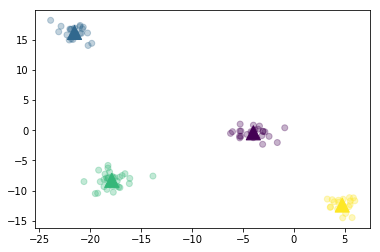

In [9]:
# compare to sklearn kmeans

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)

Note the label switching.

Comparing different initializations:

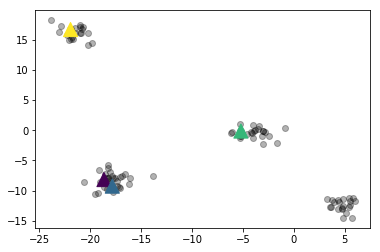

In [10]:
# pick a different initialization and re-run
npr.seed(1)

W = X[npr.choice(n, k, replace=False)]
plot_clust(X,W)

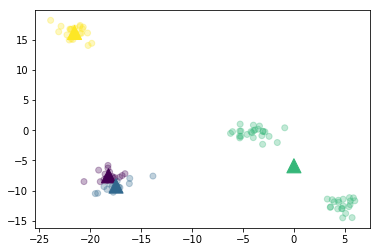

In [11]:
for itr in range(100):
    z = update_z(X,W)
    W = update_W(X,z,W)
    
plot_clust(X,W,z)

# Vector quantization demo

In [12]:
def quantize(img, bpp):
    H, W, _ = img.shape
    X = img.reshape((H*W,3))
    
    model = KMeans(n_clusters=2**bpp, n_init=3)
    quantized_img = model.fit_predict(X).reshape((H,W))
    colours = model.cluster_centers_.astype('uint8')

    return quantized_img, colours

def dequantize(quantized_img, colours):
    H, W = quantized_img.shape
    img = np.zeros((H,W,3), dtype='uint8')

    for i in range(H):
        for j in range(W):
            img[i,j] = colours[quantized_img[i,j]]

    return img



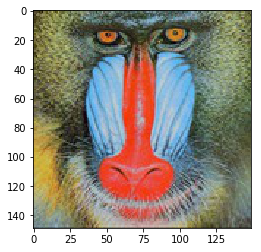

In [13]:
img = imread(os.path.join("img", "mandrill.jpg"))
plt.imshow(img);

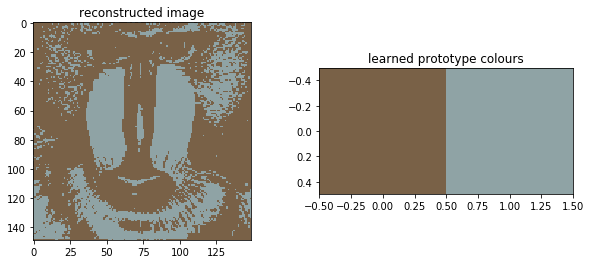

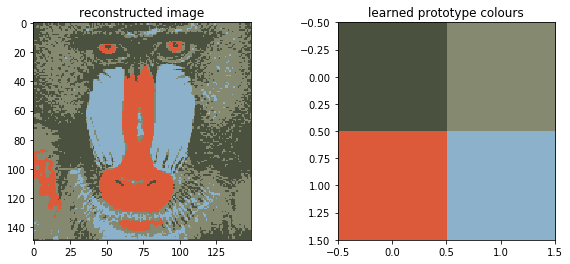

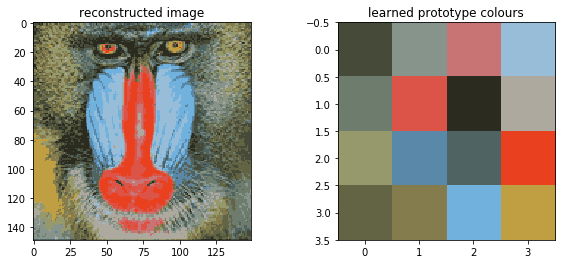

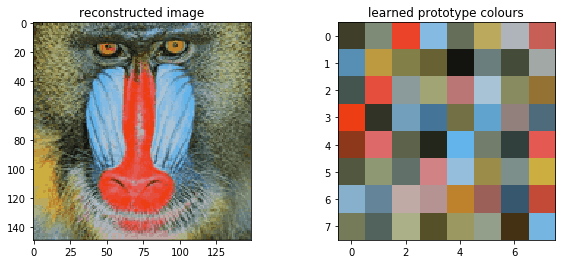

In [14]:
for bpp in [1,2,4,6]:
    q_img, colours = quantize(img, bpp)
    d_img = dequantize(q_img, colours)
#     loss = np.sum((d_img - img)**2)/np.sum(img**2)*100
#     compression_ratio = bpp/8 # + colours
    plt.figure(figsize=(10,4));
    plt.subplot(1,2,1);
    plt.imshow(d_img);
    plt.title("reconstructed image")
    plt.subplot(1,2,2);
    plt.imshow(colours[None] if bpp/2!=bpp//2 else np.reshape(colours, (2**(bpp//2),2**(bpp//2),3)));
    plt.title("learned prototype colours")
